In [1]:
#!/usr/bin/env python
# encoding: utf-8
'''
@author: KM
@license: (C) Copyright 2013-2017, Node Supply Chain Manager Corporation Limited.
@contact: yangkm601@gmail.com
@software: garner
@file: Xgboost_study.ipynb
@time: 2019/4/9 9:44
@desc:  Xgboost算法
@url:  
'''

'\n@author: KM\n@license: (C) Copyright 2013-2017, Node Supply Chain Manager Corporation Limited.\n@contact: yangkm601@gmail.com\n@software: garner\n@file: Xgboost_study.ipynb\n@time: 2019/4/9 9:44\n@desc:  Xgboost算法\n@url:  \n'

## 一、Xgboost的离线安装

### 方法1  [点击此处](https://www.lfd.uci.edu/~gohlke/pythonlibs/#xgboost),下载对应自己Python版本的网址。


![Xgboost 下载](img/xgboost_download1.png)

### 方法2 输入安装的方式

 ``` js
   
 ``` 
> pip install xgboost-0.81-cp37-cp37m-win_amd64.whl


![Xgboost 下载](img/xgboost_download2.png)


## 二、Xgboost模型详解

### 1. Xgboost 能加载的各种数据格式解析
　
 Xgboost可以加载多种数据格式的训练数据：
> libsvm 格式的文本数据；
> Numpy 的二维数组；
> XGBoost 的二进制的缓存文件。加载的数据存储在对象 DMatrix 中。
 
 下面一一列举：
 
**记载libsvm格式的数据**  
> dtrain1 = xgb.DMatrix('train.svm.txt')
 
**记载二进制的缓存文件**
> dtrain2  = xgb.DMatrix('train.svm.buffer')

**加载numpy的数组**
> data = np.random.rand(5,10)           # 5行10列数据集
> label = np.random.randint(2,size=5)      # 二分类目标值
> dtrain = xgb.DMatrix(data,label=label)    # 组成训练集

**将scipy.sparse格式的数据转化为Dmatrix格式**
> csr = scipy.sparse.csr_matrix((dat,(row,col)))
> dtrain = xgb.DMatrix( csr )

**将Dmatrix格式的数据保存成Xgboost的二进制格式，在下次加载时可以提高加载速度，使用方法如下：**
> dtrain = xgb.DMatrix('train.svm.txt')
> dtrain.save_binary("train.buffer")

**可以使用如下方式处理DMatrix中的缺失值**
> dtrain = xgb.DMatrix( data, label=label, missing = -999.0)

**当需要给样本设置权重时，可以用如下方式：**
> w = np.random.rand(5,1)
> dtrain = xgb.DMatrix( data, label=label, missing = -999.0, weight=w)


### 2 Xgboost的模型参数

Xgboost的模型参数

```python
# xgboost模型
params = {
    'booster':'gbtree',
    'objective':'multi:softmax',   # 多分类问题
    'num_class':10,  # 类别数，与multi softmax并用
    'gamma':0.1,    # 用于控制是否后剪枝的参数，越大越保守，一般0.1 0.2的样子
    'max_depth':12,  # 构建树的深度，越大越容易过拟合
    'lambda':2,  # 控制模型复杂度的权重值的L2 正则化项参数，参数越大，模型越不容易过拟合
    'subsample':0.7, # 随机采样训练样本
    'colsample_bytree':3,# 这个参数默认为1，是每个叶子里面h的和至少是多少
    # 对于正负样本不均衡时的0-1分类而言，假设h在0.01附近，min_child_weight为1
    #意味着叶子节点中最少需要包含100个样本。这个参数非常影响结果，
    # 控制叶子节点中二阶导的和的最小值，该参数值越小，越容易过拟合
    'silent':0,  # 设置成1 则没有运行信息输入，最好是设置成0
    'eta':0.007,  # 如同学习率
    'seed':1000,
    'nthread':7,  #CPU线程数
    #'eval_metric':'auc'
}

```

在运行Xgboost之前，必须设置三种类型参数：general parameters，booster parameters和task parameters：

**通用参数（General Parameters）**：该参数控制在提升（boosting）过程中使用哪种booster，常用的booster有树模型（tree）和线性模型（linear model）

**Booster参数（Booster Parameters）**：这取决于使用哪种booster

**学习目标参数（Task Parameters）**：控制学习的场景，例如在回归问题中会使用不同的参数控制排序


#### 2.1 通用参数

1. booster [default=gbtree] 
    
    - 有两种模型可以选择gbtree和gblinear。gbtree使用基于树的模型进行提升计算，gblinear使用线性模型进行提升计算。缺省值为gbtree

1. silent [default=0] 

    - 取0时表示打印出运行时信息，取1时表示以默认方式运行，不打印运行时的信息。缺省值为0
    - 建议取0，过程中的输出数据有助于理解模型以及调参。另外实际上我设置其为1也通常无法缄默运行。
    
1. nthread [default to maximum number of threads available if not set] 

    - XGBoost运行时的线程数。缺省值是当前系统可以获得的最大线程数
    - 如果你希望以最大速度运行，建议不设置这个参数，模型将自动获得最大线程
    
1. num_pbuffer [set automatically by xgboost, no need to be set by user] 

    - size of prediction buffer, normally set to number of training instances. The buffers are used to save the prediction results of last boosting step.
    
1. num_feature [set automatically by xgboost, no need to be set by user] 

    - boosting过程中用到的特征维数，设置为特征个数。XGBoost会自动设置，不需要手工设置


#### 2.2 tree booster参数

1. eta [default=0.3] 

    - 为了防止过拟合，更新过程中用到的收缩步长。在每次提升计算之后，算法会直接获得新特征的权重。 eta通过缩减特征的权重使提升计算过程更加保守。缺省值为0.3
    - 取值范围为：[0,1]
    - 通常最后设置eta为0.01~0.2
    
2. gamma [default=0] 

    - minimum loss reduction required to make a further partition on a leaf node of the tree. the larger, the more conservative the algorithm will be.
    - range: [0,∞]
    - 模型在默认情况下，对于一个节点的划分只有在其loss function 得到结果大于0的情况下才进行，而gamma 给定了所需的最低loss function的值
    - gamma值使得算法更conservation，且其值依赖于loss function ，在模型中应该进行调参。
    
2. max_depth [default=6] 

    - 树的最大深度。缺省值为6
    - 取值范围为：[1,∞]
    - 指树的最大深度
    - 树的深度越大，则对数据的拟合程度越高（过拟合程度也越高）。即该参数也是控制过拟合
    - 建议通过交叉验证（xgb.cv ) 进行调参
    - 通常取值：3-10

2. min_child_weight [default=1] 

    - 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。在现行回归模型中，这个参数是指建立每个模型所需要的最小样本数。该成熟越大算法越conservative。即调大这个参数能够控制过拟合。
    - 取值范围为: [0,∞]
    
2. max_delta_step [default=0] 

    - Maximum delta step we allow each tree’s weight estimation to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative. Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced. Set it to value of 1-10 might help control the update
    - 取值范围为：[0,∞]
    - 如果取值为0，那么意味着无限制。如果取为正数，则其使得xgboost更新过程更加保守。
    - 通常不需要设置这个值，但在使用logistics 回归时，若类别极度不平衡，则调整该参数可能有效果    
    
2. subsample [default=1] 

    - 用于训练模型的子样本占整个样本集合的比例。如果设置为0.5则意味着XGBoost将随机的从整个样本集合中抽取出50%的子样本建立树模型，这能够防止过拟合。
    - 取值范围为：(0,1]
    
2. colsample_bytree [default=1] 

    - 在建立树时对特征随机采样的比例。缺省值为1
    - 取值范围：(0,1]
    
2. colsample_bylevel[default=1]

    - 决定每次节点划分时子样例的比例
    - 通常不使用，因为subsample和colsample_bytree已经可以起到相同的作用了
    
2. scale_pos_weight[default=0]

    - A value greater than 0 can be used in case of high class imbalance as it helps in faster convergence.
    - 大于0的取值可以处理类别不平衡的情况。帮助模型更快收敛

#### 2.3 Linear Booster参数

1. lambda [default=0] 

    - L2 正则的惩罚系数
    - 用于处理XGBoost的正则化部分。通常不使用，但可以用来降低过拟合
    
3. alpha [default=0] 

    - L1 正则的惩罚系数
    - 当数据维度极高时可以使用，使得算法运行更快。

3. lambda_bias 

    - 在偏置上的L2正则。缺省值为0（在L1上没有偏置项的正则，因为L1时偏置不重要）

#### 2.4 学习目标参数

这个参数是来控制理想的优化目标和每一步结果的度量方法。

1. objective [ default=reg:linear ] 

    - 定义学习任务及相应的学习目标，可选的目标函数如下：
    - “reg:linear” –线性回归。
    - “reg:logistic” –逻辑回归。
    - “binary:logistic” –二分类的逻辑回归问题，输出为概率。
    - “binary:logitraw” –二分类的逻辑回归问题，输出的结果为wTx。
    - “count:poisson” –计数问题的poisson回归，输出结果为poisson分布。
    - 在poisson回归中，max_delta_step的缺省值为0.7。(used to safeguard optimization)
    - “multi:softmax” –让XGBoost采用softmax目标函数处理多分类问题，同时需要设置参数num_class（类别个数）
    - “multi:softprob” –和softmax一样，但是输出的是ndata * nclass的向量，可以将该向量reshape成ndata行nclass列的矩阵。每行数据表示样本所属于每个类别的概率。
    - “rank:pairwise” –set XGBoost to do ranking task by minimizing the pairwise loss

2. base_score [ default=0.5 ] 

    - the initial prediction score of all instances, global bias

3. eval_metric [ default according to objective ] 

    - 校验数据所需要的评价指标，不同的目标函数将会有缺省的评价指标（rmse for regression, and error for classification, mean average precision for ranking）
    - 用户可以添加多种评价指标，对于Python用户要以list传递参数对给程序，而不是map参数list参数不会覆盖’eval_metric’
    - The choices are listed below:
    - “rmse”: root mean square error
    - “logloss”: negative log-likelihood
    - “error”: Binary classification error rate. It is calculated as #(wrong cases)/#(all cases). For the predictions, the evaluation will regard the instances with prediction value larger than 0.5 as positive instances, and the others as negative instances.
    - “merror”: Multiclass classification error rate. It is calculated as #(wrong cases)/#(all cases).
    - “mlogloss”: Multiclass logloss
    - “auc”: Area under the curve for ranking evaluation.
    - “ndcg”:Normalized Discounted Cumulative Gain
    - “map”:Mean average precision
    - “ndcg@n”,”map@n”: n can be assigned as an integer to cut off the top positions in the lists for evaluation.
    - “ndcg-“,”map-“,”ndcg@n-“,”map@n-“: In XGBoost, NDCG and MAP will evaluate the score of a list without any positive samples as 1. By adding “-” in the evaluation metric XGBoost will evaluate these score as 0 to be consistent under some conditions. 
    - training repeatively
    
4. seed [ default=0 ] 

    - 随机数的种子。缺省值为0
    - 可以用于产生可重复的结果（每次取一样的seed即可得到相同的随机划分）
    ![loss](img/xgboost_loss.png)

### 3 Xgboost基本方法和默认参数

> xgboost.train(params,dtrain,num_boost_round=10,evals(),obj=None,
> feval=None,maximize=False,early_stopping_rounds=None,evals_result=None,
> verbose_eval=True,learning_rates=None,xgb_model=None)



- parms：这是一个字典，里面包含着训练中的参数关键字和对应的值，形式是parms = {'booster':'gbtree','eta':0.1}
- dtrain：训练的数据
- num_boost_round：这是指提升迭代的个数
- evals：这是一个列表，用于对训练过程中进行评估列表中的元素。形式是evals = [(dtrain,'train'),(dval,'val')] 或者是 evals =[(dtrain,'train')] ，对于第一种情况，它使得我们可以在训练过程中观察验证集的效果。
- obj ：自定义目的函数
- feval：自定义评估函数
- maximize：是否对评估函数进行最大化
- early_stopping_rounds：早起停止次数，假设为100，验证集的误差迭代到一定程度在100次内不能再继续降低，就停止迭代。这要求evals里至少有一个元素，如果有多个，按照最后一个去执行。返回的是最后的迭代次数（不是最好的）。如果early_stopping_rounds存在，则模型会生成三个属性，bst.best_score ,bst.best_iteration和bst.best_ntree_limit
- evals_result：字典，存储在watchlist中的元素的评估结果
- verbose_eval（可以输入布尔型或者数值型）：也要求evals里至少有一个元素，如果为True，则对evals中元素的评估结果会输出在结果中；如果输入数字，假设为5，则每隔5个迭代输出一次。
- learning_rates：每一次提升的学习率的列表
- xgb_model：在训练之前用于加载的xgb_model

### 4.模型训练

有了参数列表和数据就可以训练模型了

> num_round = 10
>
> bst = xgb.train( plst, dtrain, num_round, evallist )

### 5. 模型预测

>#X_test类型可以是二维List，也可以是numpy的数组 
>
>dtest = DMatrix(X_test)
>
>ans = model.predict(dtest) 


### 6.保存模型

　　在训练完成之后可以将模型保存下来，也可以查看模型内部的结构
  
  > bst.save_model('test.model')
  
   导出模型和特征映射（Map）

　　你可以导出模型到txt文件并浏览模型的含义：
  
  > #导出模型到文件
  >
  >bst.dump_model('dump.raw.txt')
  >
  > #导出模型和特征映射
  >
  >bst.dump_model('dump.raw.txt','featmap.txt')

### 7.加载模型

通过如下方式可以加载模型

> bst = xgb.Booster({'nthread':4})  # init model
>
> bst.load_model("model.bin")     # load data

## 三、Xgboost实战

Xgboost有两大类接口：Xgboost原生接口 和sklearn接口，并且Xgboost能够实现分类回归两种任务。下面对这四种情况做以解析。

### 1. 基于Xgboost原生接口的分类


accuarcy:93.33%


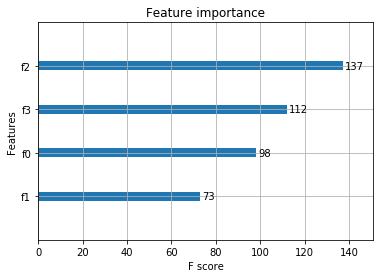

In [4]:
from sklearn.datasets import load_iris
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot  as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score  # 准确率
 
# 记载样本数据集
iris = load_iris()
X,y = iris.data,iris.target
# 数据集分割
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123457)
 
# 算法参数
params = {
    'booster':'gbtree',
    'objective':'multi:softmax',
    'num_class':3,
    'gamma':0.1,
    'max_depth':6,
    'lambda':2,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'min_child_weight':3,
    'slient':1,
    'eta':0.1,
    'seed':1000,
    'nthread':4,
}
 
plst = params.items()
 
# 生成数据集格式
dtrain = xgb.DMatrix(X_train,y_train)
num_rounds = 500
# xgboost模型训练
model = xgb.train(plst,dtrain,num_rounds)
 
# 对测试集进行预测
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)
 
# 计算准确率
accuracy = accuracy_score(y_test,y_pred)
print('accuarcy:%.2f%%'%(accuracy*100))
 
# 显示重要特征
plot_importance(model)
plt.show()

### 2. 基于Xgboost原生接口的回归


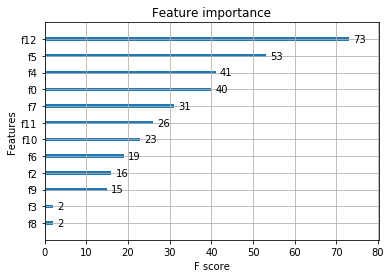

In [5]:
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
 
# 加载数据集,此数据集时做回归的
boston = load_boston()
X,y = boston.data,boston.target
 
# Xgboost训练过程
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
 
# 算法参数
params = {
    'booster':'gbtree',
    'objective':'reg:gamma',
    'gamma':0.1,
    'max_depth':5,
    'lambda':3,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'min_child_weight':3,
    'slient':1,
    'eta':0.1,
    'seed':1000,
    'nthread':4,
}
 
dtrain = xgb.DMatrix(X_train,y_train)
num_rounds = 300
plst = params.items()
model = xgb.train(plst,dtrain,num_rounds)
 
# 对测试集进行预测
dtest = xgb.DMatrix(X_test)
ans = model.predict(dtest)
 
# 显示重要特征
plot_importance(model)
plt.show()

### 3. Xgboost使用sklearn接口的分类（推荐）

In [6]:
# XGBClassifier
from xgboost.sklearn import XGBClassifier
 
clf = XGBClassifier(
    silent=0,  # 设置成1则没有运行信息输出，最好是设置为0，是否在运行升级时打印消息
    # nthread = 4  # CPU 线程数 默认最大
    learning_rate=0.3 , # 如同学习率
    min_child_weight = 1,
    # 这个参数默认为1，是每个叶子里面h的和至少是多少，对正负样本不均衡时的0-1分类而言
    # 假设h在0.01附近，min_child_weight为1 意味着叶子节点中最少需要包含100个样本
    # 这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易过拟合
    max_depth=6, # 构建树的深度，越大越容易过拟合
    gamma = 0,# 树的叶子节点上做进一步分区所需的最小损失减少，越大越保守，一般0.1 0.2这样子
    subsample=1, # 随机采样训练样本，训练实例的子采样比
    max_delta_step=0,  # 最大增量步长，我们允许每个树的权重估计
    colsample_bytree=1, # 生成树时进行的列采样
    reg_lambda=1, #控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合
    # reg_alpha=0, # L1正则项参数
    # scale_pos_weight =1 # 如果取值大于0的话，在类别样本不平衡的情况下有助于快速收敛，平衡正负权重
    # objective = 'multi:softmax', # 多分类问题，指定学习任务和响应的学习目标
    # num_class = 10,  # 类别数，多分类与multisoftmax并用
    n_estimators=100,  # 树的个数
    seed = 1000,  # 随机种子
    # eval_metric ='auc'
)

accuracy:93%


d:\progrom\python\python\python3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


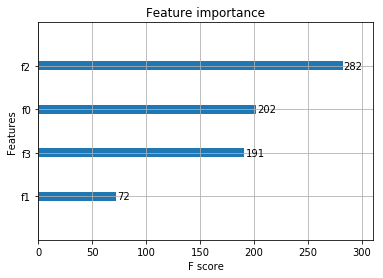

In [7]:
# 基于Sckit-learn接口的分类
from sklearn.datasets import load_iris
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
 
# 加载样本数据集
iris = load_iris()
X,y = iris.data,iris.target
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=12343)
 
# 训练模型
model = xgb.XGBClassifier(max_depth=5,learning_rate=0.1,n_estimators=160,silent=True,objective='multi:softmax')
model.fit(X_train,y_train)
 
# 对测试集进行预测
y_pred = model.predict(X_test)
 
#计算准确率
accuracy = accuracy_score(y_test,y_pred)
print('accuracy:%2.f%%'%(accuracy*100))
 
# 显示重要特征
plot_importance(model)
plt.show()

### 4.基于Scikit-learn接口的回归

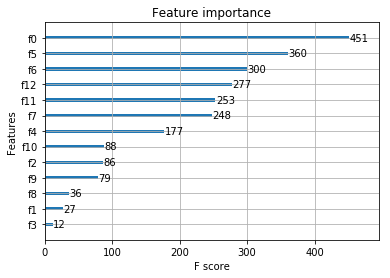

In [8]:
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
 
# 导入数据集
boston = load_boston()
X ,y = boston.data,boston.target
 
# Xgboost训练过程
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
 
model = xgb.XGBRegressor(max_depth=5,learning_rate=0.1,n_estimators=160,silent=True,objective='reg:gamma')
model.fit(X_train,y_train)
 
# 对测试集进行预测
ans = model.predict(X_test)
 
# 显示重要特征
plot_importance(model)
plt.show()

### 5.整理代码1（原生XGB）


In [10]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from  sklearn.datasets  import  make_hastie_10_2
import xgboost as xgb
#记录程序运行时间
import time
start_time = time.time()
X, y = make_hastie_10_2(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)##test_size测试集合所占比例
#xgb矩阵赋值
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test = xgb.DMatrix(X_test,label=y_test)
##参数
params={
'booster':'gbtree',
'silent':1 ,#设置成1则没有运行信息输出，最好是设置为0.
#'nthread':7,# cpu 线程数 默认最大
'eta': 0.007, # 如同学习率
'min_child_weight':3,
# 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
#，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
#这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。
'max_depth':6, # 构建树的深度，越大越容易过拟合
'gamma':0.1,  # 树的叶子节点上作进一步分区所需的最小损失减少,越大越保守，一般0.1、0.2这样子。
'subsample':0.7, # 随机采样训练样本
'colsample_bytree':0.7, # 生成树时进行的列采样
'lambda':2,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
#'alpha':0, # L1 正则项参数
#'scale_pos_weight':1, #如果取值大于0的话，在类别样本不平衡的情况下有助于快速收敛。
#'objective': 'multi:softmax', #多分类的问题
#'num_class':10, # 类别数，多分类与 multisoftmax 并用
'seed':1000, #随机种子
#'eval_metric': 'auc'
}
plst = list(params.items())
num_rounds = 100 # 迭代次数
watchlist = [(xgb_train, 'train'),(xgb_test, 'val')]
  
#训练模型并保存
# early_stopping_rounds 当设置的迭代次数较大时，early_stopping_rounds 可在一定的迭代次数内准确率没有提升就停止训练
model = xgb.train(plst, xgb_train, num_rounds, watchlist,early_stopping_rounds=100)
#model.save_model('./model/xgb.model') # 用于存储训练出的模型
print("best best_ntree_limit",model.best_ntree_limit)
y_pred = model.predict(xgb_test,ntree_limit=model.best_ntree_limit)
print ('error=%f' % (  sum(1 for i in range(len(y_pred)) if int(y_pred[i]>0.5)!=y_test[i]) /float(len(y_pred)))) 
#输出运行时长
cost_time = time.time()-start_time
print("xgboost success!",'\n',"cost time:",cost_time,"(s)......")

[0]	train-rmse:1.12759	val-rmse:1.11301
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[1]	train-rmse:1.12464	val-rmse:1.11037
[2]	train-rmse:1.12178	val-rmse:1.10785
[3]	train-rmse:1.11892	val-rmse:1.10527
[4]	train-rmse:1.11604	val-rmse:1.10274
[5]	train-rmse:1.11336	val-rmse:1.10033
[6]	train-rmse:1.11055	val-rmse:1.09783
[7]	train-rmse:1.10777	val-rmse:1.09537
[8]	train-rmse:1.10495	val-rmse:1.0929
[9]	train-rmse:1.10219	val-rmse:1.09047
[10]	train-rmse:1.09952	val-rmse:1.08804
[11]	train-rmse:1.09683	val-rmse:1.08564
[12]	train-rmse:1.09411	val-rmse:1.08323
[13]	train-rmse:1.09148	val-rmse:1.08083
[14]	train-rmse:1.08884	val-rmse:1.07851
[15]	train-rmse:1.08631	val-rmse:1.07626
[16]	train-rmse:1.0837	val-rmse:1.07396
[17]	train-rmse:1.08118	val-rmse:1.07173
[18]	train-rmse:1.07864	val-rmse:1.06942
[19]	train-rmse:1.07607	val-rmse:1.06712
[20]	train-rmse:1.07357	val-rmse:1.06485
[21]	trai

### 6. 整理代码2（XGB使用sklearn）

In [13]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from  sklearn.datasets  import  make_hastie_10_2
from xgboost.sklearn import XGBClassifier
X, y = make_hastie_10_2(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)##test_size测试集合所占比例
clf = XGBClassifier(
silent=0 ,#设置成1则没有运行信息输出，最好是设置为0.是否在运行升级时打印消息。
#nthread=4,# cpu 线程数 默认最大
learning_rate= 0.3, # 如同学习率
min_child_weight=1,
# 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
#，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
#这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。
max_depth=6, # 构建树的深度，越大越容易过拟合
gamma=0,  # 树的叶子节点上作进一步分区所需的最小损失减少,越大越保守，一般0.1、0.2这样子。
subsample=1, # 随机采样训练样本 训练实例的子采样比
max_delta_step=0,#最大增量步长，我们允许每个树的权重估计。
colsample_bytree=1, # 生成树时进行的列采样
reg_lambda=1,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
#reg_alpha=0, # L1 正则项参数
#scale_pos_weight=1, #如果取值大于0的话，在类别样本不平衡的情况下有助于快速收敛。平衡正负权重
#objective= 'multi:softmax', #多分类的问题 指定学习任务和相应的学习目标
#num_class=10, # 类别数，多分类与 multisoftmax 并用
n_estimators=100, #树的个数
seed=1000 #随机种子
#eval_metric= 'auc'
)
clf.fit(X_train,y_train,eval_metric='auc')
#设置验证集合 verbose=False不打印过程
clf.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],eval_metric='auc',verbose=False)
#获取验证集合结果
evals_result = clf.evals_result()
y_true, y_pred = y_test, clf.predict(X_test)
print("Accuracy : %.4g" % metrics.accuracy_score(y_true, y_pred))
#回归
#m_regress = xgb.XGBRegressor(n_estimators=1000,seed=0)

Accuracy : 0.9177


d:\progrom\python\python\python3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## 四、Xgboost参数调优的一般方法

### 1. 调参步骤：

　　1，选择较高的学习速率（learning rate）。一般情况下，学习速率的值为0.1.但是，对于不同的问题，理想的学习速率有时候会在0.05~0.3之间波动。选择对应于此学习速率的理想决策树数量。Xgboost有一个很有用的函数“cv”，这个函数可以在每一次迭代中使用交叉验证，并返回理想的决策树数量。

　　2，对于给定的学习速率和决策树数量，进行决策树特定参数调优（max_depth , min_child_weight , gamma , subsample,colsample_bytree）在确定一棵树的过程中，我们可以选择不同的参数。

　　3，Xgboost的正则化参数的调优。（lambda , alpha）。这些参数可以降低模型的复杂度，从而提高模型的表现。

　　4，降低学习速率，确定理想参数。

　　下面详细的进行这些操作。

#### 第一步：确定学习速率和tree_based参数调优的估计器数目

为了确定Boosting参数，我们要先给其他参数一个初始值。咱们先按照如下方法取值：

1. max_depth = 5：这个参数的取值最好在3-10之间，我选的起始值为5，但是你可以选择其他的值。起始值在4-6之间都是不错的选择。
2. min_child_weight = 1 ：这里选择了一个比较小的值，因为这是一个极不平衡的分类问题。因此，某些叶子节点下的值会比较小。
3. gamma = 0 :起始值也可以选择其它比较小的值，在0.1到0.2之间就可以，这个参数后继也是要调整的。
4. subsample,colsample_bytree = 0.8  这个是最常见的初始值了。典型值的范围在0.5-0.9之间。
5. scale_pos_weight =1 这个值时因为类别十分不平衡。
    
　　注意，上面这些参数的值知识一个初始的估计值，后继需要调优。这里把学习速率就设成默认的0.1。然后用Xgboost中的cv函数来确定最佳的决策树数量。

In [14]:
from xgboost import XGBClassifier
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

#### 第二步：max_depth和min_weight参数调优
　　
   我们先对这两个参数调优，是因为他们对最终结果有很大的影响。首先，我们先大范围地粗略参数，然后再小范围的微调。

　　注意：在这一节我会进行高负荷的栅格搜索（grid search），这个过程大约需要15-30分钟甚至更久，具体取决于你系统的性能，你也可以根据自己系统的性能选择不同的值。

　　网格搜索scoring = 'roc_auc' 只支持二分类，多分类需要修改scoring（默认支持多分类）

In [16]:
param_test1 = {
     'max_depth':range(3,10,2),
     'min_child_weight':range(1,6,2)
}
#param_test2 = {
     'max_depth':[4,5,6],
     'min_child_weight':[4,5,6]
}
from sklearn import svm, grid_search, datasets
from sklearn import grid_search
gsearch1 = grid_search.GridSearchCV(
estimator = XGBClassifier(
learning_rate =0.1,
n_estimators=140, max_depth=5,
min_child_weight=1,
gamma=0,
subsample=0.8,
colsample_bytree=0.8,
objective= 'binary:logistic',
nthread=4,
scale_pos_weight=1,
seed=27),
param_grid = param_test1,
scoring='roc_auc',
n_jobs=4,
iid=False,
cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_,gsearch1.best_score_
#网格搜索scoring='roc_auc'只支持二分类，多分类需要修改scoring(默认支持多分类)

IndentationError: unexpected indent (<ipython-input-16-755fc87ebf12>, line 6)

### 第三步：gamma参数调优

　　在已经调整好其他参数的基础上，我们可以进行gamma参数的调优了。Gamma参数取值范围很大，这里我们设置为5，其实你也可以取更精确的gamma值。

In [17]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
 
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1,
 n_estimators=140, max_depth=4,min_child_weight=6, gamma=0,
subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic',
nthread=4, scale_pos_weight=1,seed=27),  param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
 
gsearch3.fit(train[predictors],train[target])
 
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

NameError: name 'GridSearchCV' is not defined

In [18]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(
estimator = XGBClassifier(
learning_rate =0.1,
n_estimators=140,
max_depth=4,
min_child_weight=6,
gamma=0,
subsample=0.8,
colsample_bytree=0.8,
objective= 'binary:logistic',
nthread=4,
scale_pos_weight=1,
seed=27),
param_grid = param_test3,
scoring='roc_auc',
n_jobs=4,
iid=False,
cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

NameError: name 'GridSearchCV' is not defined

#### 第四步：调整subsample 和 colsample_bytree参数

　　尝试不同的subsample 和 colsample_bytree 参数。我们分两个阶段来进行这个步骤。这两个步骤都取0.6,0.7,0.8,0.9作为起始值。

In [ ]:
#取0.6,0.7,0.8,0.9作为起始值
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
  
gsearch4 = GridSearchCV(
estimator = XGBClassifier(
learning_rate =0.1,
n_estimators=177,
max_depth=3,
min_child_weight=4,
gamma=0.1,
subsample=0.8,
colsample_bytree=0.8,
objective= 'binary:logistic',
nthread=4,
scale_pos_weight=1,
seed=27),
param_grid = param_test4,
scoring='roc_auc',
n_jobs=4,
iid=False,
cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

#### 第五步：正则化参数调优

　　由于gamma函数提供了一种更加有效的降低过拟合的方法，大部分人很少会用到这个参数，但是我们可以尝试用一下这个参数。

In [ ]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(
estimator = XGBClassifier(
learning_rate =0.1,
n_estimators=177,
max_depth=4,
min_child_weight=6,
gamma=0.1,
subsample=0.8,
colsample_bytree=0.8,
objective= 'binary:logistic',
nthread=4,
scale_pos_weight=1,
seed=27),
param_grid = param_test6,
scoring='roc_auc',
n_jobs=4,
iid=False,
cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

#### 第六步：降低学习速率

　　最后，我们使用较低的学习速率，以及使用更多的决策树，我们可以用Xgboost中CV函数来进行这一步工作。

In [ ]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)

总结一下，要想模型的表现有大幅的提升，调整每个参数带来的影响也必须清楚，仅仅靠着参数的调整和模型的小幅优化，想要让模型的表现有个大幅度提升是不可能的。要想模型的表现有质的飞跃，需要依靠其他的手段。诸如，特征工程(feature egineering) ，模型组合(ensemble of model),以及堆叠(stacking)等。

#### 第七步：Python示例

d:\progrom\python\python\python3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy : 0.98
Accuracy : 0.98


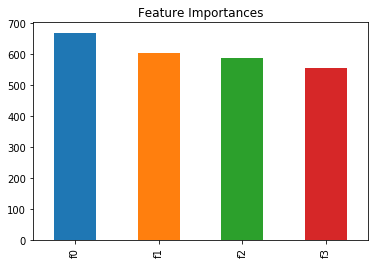

In [21]:
import xgboost as xgb
import pandas as pd
#获取数据
from sklearn import cross_validation
from sklearn.datasets import load_iris
iris = load_iris()
#切分数据集
X_train, X_test, y_train, y_test = cross_validation.train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)
#设置参数
m_class = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)
#训练
m_class.fit(X_train, y_train)
test_21 = m_class.predict(X_test)
print("Accuracy : %.2f" % metrics.accuracy_score(y_test, test_21))
#预测概率
#test_2 = m_class.predict_proba(X_test)
#查看AUC评价标准
from sklearn import metrics
print("Accuracy : %.2f" % metrics.accuracy_score(y_test, test_21))
##必须二分类才能计算
##print "AUC Score (Train): %f" % metrics.roc_auc_score(y_test, test_2)
#查看重要程度
feat_imp = pd.Series(m_class.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
import matplotlib.pyplot as plt
plt.show()
#回归
#m_regress = xgb.XGBRegressor(n_estimators=1000,seed=0)
#m_regress.fit(X_train, y_train)
#test_1 = m_regress.predict(X_test)

### ERROR 

> xgboost model getfscore:'str' object is not callable
    
```
    feat_imp = pd.Series(xgbPara.booster().get_fscore()).sort_values(ascending=False) 

    TypeError: 'str' object is not callable
```

>**method**:
>
> Replace xgbPara.booster() with xgbPara.get_booster(), if that wont work, you have a version mismatch and you need to upgrade either sklearn, xgboost or both. Hope this helps.

[问题解决方法链接](https://stackoverflow.com/questions/53332462/xgboost-model-getfscorestr-object-is-not-callable)

### 五、XGBoost输出特征重要性以及筛选特征

####  1.梯度提升算法是如何计算特征重要性的？

使用梯度提升算法的好处是在提升树被创建后，可以相对直接地得到每个属性的重要性得分。一般来说，重要性分数，衡量了特征在模型中的提升决策树构建中的价值。一个属性越多的被用来在模型中构建决策树，它的重要性就相对越高。

属性重要性是通过对数据集中的每个属性进行计算，并进行排序得到。在单个决策树中通过每个属性分裂点改进性能度量的量来计算属性重要性。由节点负责加权和记录次数，也就是说一个属性对分裂点改进性能度量越大（越靠近根节点），权值越大；被越多提升树所选择，属性越重要。性能度量可以是选择分裂节点的Gini纯度，也可以是其他度量函数。

最终将一个属性在所有提升树中的结果进行加权求和后然后平均，得到重要性得分。

#### 2. 绘制特征重要性

一个已训练的Xgboost模型能够自动计算特征重要性，这些重要性得分可以通过成员变量feature_importances_得到。可以通过如下命令打印：

> print(model.feature_importances_)

我们可以直接在条形图上绘制这些分数，以便获得数据集中每个特征的相对重要性的直观显示，例如：

> #plot
>
> pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
>
> pyplot.show()

我们可以通过在the Pima Indians onset of diabetes 数据集上训练XGBoost模型来演示，并从计算的特征重要性中绘制条形图。

[0.01239746 0.03404614 0.5992223  0.35433412]


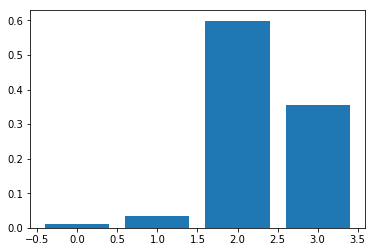

In [22]:
# plot feature importance manually
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot
from sklearn.datasets import load_iris
# load data
dataset = load_iris()
# split data into X and y
X = dataset.data
y = dataset.target
# fit model no training data
model = XGBClassifier()
model.fit(X, y)
# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

这种绘制的缺点在于，只显示了特征重要性而没有排序，可以在绘制之前对特征重要性得分进行排序。

通过内建的绘制函数进行特征重要性得分排序后的绘制，这个函数就是plot_importance()，示例如下：

[0.01239746 0.03404614 0.5992223  0.35433412]


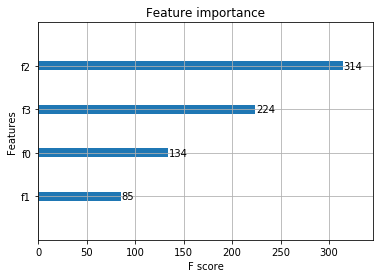

In [23]:
# plot feature importance manually
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot
from sklearn.datasets import load_iris
from xgboost import plot_importance
 
# load data
dataset = load_iris()
# split data into X and y
X = dataset.data
y = dataset.target
# fit model no training data
model = XGBClassifier()
model.fit(X, y)
# feature importance
print(model.feature_importances_)
# plot feature importance
 
plot_importance(model)
pyplot.show()

根据其在输入数组的索引，特征被自动命名为f0~f3，在问题描述中手动的将这些索引映射到名称，我们可以看到，f2具有最高的重要性，f1具有最低的重要性。

#### 3. 根据Xgboost特征重要性得分进行特征选择

特征重要性得分，可以用于在scikit-learn中进行特征选择。通过SelectFromModel类实现，该类采用模型并将数据集转换为具有选定特征的子集。这个类可以采取预先训练的模型，例如在整个数据集上训练的模型。然后，它可以阈值来决定选择哪些特征。当在SelectFromModel实例上调用transform()方法时，该阈值被用于在训练集和测试集上一致性选择相同特征。

在下面的示例中，我们首先在训练集上训练xgboost模型，然后在测试上评估。使用从训练数据集计算的特征重要性，然后，将模型封装在一个SelectFromModel实例中。我们使用这个来选择训练集上的特征，用所选择的特征子集训练模型，然后在相同的特征方案下对测试集进行评估。

>#select features using threshold
>
>selection = SelectFromModel(model, threshold=thresh, prefit=True)
>
>select_X_train = selection.transform(X_train)
>
>#train model
>
>selection_model = XGBClassifier()
>
>selection_model.fit(select_X_train, y_train)
>
>#eval model
>
>select_X_test = selection.transform(X_test)
>
>y_pred = selection_model.predict(select_X_test)

我们可以通过测试多个阈值，来从特征重要性中选择特征。具体而言，每个输入变量的特征重要性，本质上允许我们通过重要性来测试每个特征子集。

In [24]:
# 完整代码如下：
# plot feature importance manually
import numpy as np
from xgboost import XGBClassifier
from matplotlib import pyplot
from sklearn.datasets import load_iris
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
 
# load data
dataset = load_iris()
# split data into X and y
X = dataset.data
y = dataset.target
 
# split data into train and test sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=7)
 
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# feature importance
print(model.feature_importances_)
 
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test,predictions)
print("Accuracy:%.2f%%"%(accuracy*100.0))
 
#fit model using each importance as a threshold
thresholds = np.sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model,threshold=thresh,prefit=True )
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test,predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy * 100.0))

[0.01590523 0.13336425 0.4745309  0.37619963]
Accuracy:92.00%
Thresh=0.016, n=4, Accuracy: 92.00%


d:\progrom\python\python\python3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
d:\progrom\python\python\python3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
d:\progrom\python\python\python3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
d:\progrom\python\python\python3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is a

Thresh=0.133, n=3, Accuracy: 92.00%
Thresh=0.376, n=2, Accuracy: 94.00%
Thresh=0.475, n=1, Accuracy: 90.00%


d:\progrom\python\python\python3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


我们可以看到，模型的性能通常随着所选择的特征的数量减少，在这一问题上，可以对测试集准确率和模型复杂度做一个权衡，例如选择三个特征，接受准确率为92%，这可能是对这样一个小数据集的清洗，但是对于更大的数据集和使用交叉验证作为模型评估方案可能是更有用的策略。

#### 4.网格搜索


In [26]:
# 代码1：

from sklearn.model_selection import GridSearchCV
tuned_parameters= [{'n_estimators':[100,200,500],
                  'max_depth':[3,5,7], ##range(3,10,2)
                  'learning_rate':[0.5, 1.0],
                  'subsample':[0.75,0.8,0.85,0.9]
                  }]
tuned_parameters= [{'n_estimators':[100,200,500,1000]
                  }]
clf = GridSearchCV(XGBClassifier(silent=0,nthread=4,learning_rate= 0.5,min_child_weight=1, max_depth=3,gamma=0,subsample=1,colsample_bytree=1,reg_lambda=1,seed=1000), param_grid=tuned_parameters,scoring='roc_auc',n_jobs=4,iid=False,cv=5) 
clf.fit(X_train, y_train)
##clf.grid_scores_, clf.best_params_, clf.best_score_
print(clf.best_params_)
y_true, y_pred = y_test, clf.predict(X_test)
print("Accuracy : %.4g" % metrics.accuracy_score(y_true, y_pred))
y_proba=clf.predict_proba(X_test)[:,1]
print("AUC Score (Train): %f" % metrics.roc_auc_score(y_true, y_proba))

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
d:\progrom\python\python\python3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...hon3\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
d:\progrom\python\python\python3\lib\runpy.py in _run_code(code=<code object <module> at 0x000001F9AC79DB70, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'd:\progrom\python\python\python3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'd:\progrom\python\python\python3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...hon3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'd:\\progrom\...n3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...hon3\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x000001F9AC79DB70, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'd:\progrom\python\python\python3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'd:\progrom\python\python\python3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...hon3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'd:\\progrom\...n3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\traitlets-4.3.2-py3.6.egg\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    500         if self.poller is not None:
    501             self.poller.start()
    502         self.kernel.start()
    503         self.io_loop = ioloop.IOLoop.current()
    504         try:
--> 505             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    506         except KeyboardInterrupt:
    507             pass
    508 
    509 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\tornado\platform\asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    107         except RuntimeError:
    108             old_loop = None
    109         try:
    110             self._setup_logging()
    111             asyncio.set_event_loop(self.asyncio_loop)
--> 112             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Win...EventLoop running=True closed=False debug=False>>
    113         finally:
    114             asyncio.set_event_loop(old_loop)
    115 
    116     def stop(self):

...........................................................................
d:\progrom\python\python\python3\lib\asyncio\base_events.py in run_forever(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
    416             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    417                                    finalizer=self._asyncgen_finalizer_hook)
    418         try:
    419             events._set_running_loop(self)
    420             while True:
--> 421                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_Windo...EventLoop running=True closed=False debug=False>>
    422                 if self._stopping:
    423                     break
    424         finally:
    425             self._stopping = False

...........................................................................
d:\progrom\python\python\python3\lib\asyncio\base_events.py in _run_once(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
   1421                         logger.warning('Executing %s took %.3f seconds',
   1422                                        _format_handle(handle), dt)
   1423                 finally:
   1424                     self._current_handle = None
   1425             else:
-> 1426                 handle._run()
        handle._run = <bound method Handle._run of <Handle IOLoop._run_callback(functools.par...8E8>, ...]))>))>>
   1427         handle = None  # Needed to break cycles when an exception occurs.
   1428 
   1429     def _set_coroutine_wrapper(self, enabled):
   1430         try:

...........................................................................
d:\progrom\python\python\python3\lib\asyncio\events.py in _run(self=<Handle IOLoop._run_callback(functools.par...8E8>, ...]))>))>)
    122             self._callback = None
    123             self._args = None
    124 
    125     def _run(self):
    126         try:
--> 127             self._callback(*self._args)
        self._callback = <bound method IOLoop._run_callback of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (functools.partial(<function wrap.<locals>.null_w...C36830>, <zmq.sugar.fr...001F9AEC368E8>, ...]))>),)
    128         except Exception as exc:
    129             cb = _format_callback_source(self._callback, self._args)
    130             msg = 'Exception in callback {}'.format(cb)
    131             context = {

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\tornado\ioloop.py in _run_callback(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, callback=functools.partial(<function wrap.<locals>.null_w...C36830>, <zmq.sugar.fr...001F9AEC368E8>, ...]))>))
    755         """Runs a callback with error handling.
    756 
    757         For use in subclasses.
    758         """
    759         try:
--> 760             ret = callback()
        ret = undefined
        callback = functools.partial(<function wrap.<locals>.null_w...C36830>, <zmq.sugar.fr...001F9AEC368E8>, ...]))>)
    761             if ret is not None:
    762                 from tornado import gen
    763                 # Functions that return Futures typically swallow all
    764                 # exceptions and store them in the Future.  If a Future

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<Future finished result=(10, 70, <bound method.....EC36830>, <zmq.sugar.fr...001F9AEC368E8>, ...]))>,), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<Future finished result=(10, 70, <bound method.....EC36830>, <zmq.sugar.fr...001F9AEC368E8>, ...]))>,)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\tornado\gen.py in inner(f=None)
   1194             return False
   1195         elif not self.future.done():
   1196             def inner(f):
   1197                 # Break a reference cycle to speed GC.
   1198                 f = None # noqa
-> 1199                 self.run()
   1200             self.io_loop.add_future(
   1201                 self.future, inner)
   1202             return False
   1203         return True

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\tornado\gen.py in run(self=<tornado.gen.Runner object>)
   1108                         finally:
   1109                             # Break up a reference to itself
   1110                             # for faster GC on CPython.
   1111                             exc_info = None
   1112                     else:
-> 1113                         yielded = self.gen.send(value)
        yielded = undefined
        self.gen.send = <built-in method send of generator object>
        value = (10, 70, <bound method Kernel.dispatch_shell of <ipykernel.ipkernel.IPythonKernel object>>, (<zmq.eventloop.zmqstream.ZMQStream object>, [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]))
   1114 
   1115                     if stack_context._state.contexts is not orig_stack_contexts:
   1116                         self.gen.throw(
   1117                             stack_context.StackContextInconsistentError(

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\ipykernel\kernelbase.py in process_one(self=<ipykernel.ipkernel.IPythonKernel object>, wait=True)
    352         else:
    353             try:
    354                 priority, t, dispatch, args = self.msg_queue.get_nowait()
    355             except QueueEmpty:
    356                 return None
--> 357         yield gen.maybe_future(dispatch(*args))
        dispatch = <bound method Kernel.dispatch_shell of <ipykernel.ipkernel.IPythonKernel object>>
        args = (<zmq.eventloop.zmqstream.ZMQStream object>, [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    358 
    359     @gen.coroutine
    360     def dispatch_queue(self):
    361         """Coroutine to preserve order of message handling

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\tornado\gen.py in wrapper(*args=(<ipykernel.ipkernel.IPythonKernel object>, <zmq.eventloop.zmqstream.ZMQStream object>, [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]), **kwargs={})
    310                 # never actually yields, which in turn allows us to
    311                 # use "optional" coroutines in critical path code without
    312                 # performance penalty for the synchronous case.
    313                 try:
    314                     orig_stack_contexts = stack_context._state.contexts
--> 315                     yielded = next(result)
        yielded = undefined
        result = <generator object dispatch_shell>
    316                     if stack_context._state.contexts is not orig_stack_contexts:
    317                         yielded = _create_future()
    318                         yielded.set_exception(
    319                             stack_context.StackContextInconsistentError(

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '# 代码1：\n\nfrom sklearn.model_selection import Grid...n): %f" % metrics.roc_auc_score(y_true, y_proba))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 4, 9, 12, 35, 37, 992234, tzinfo=tzutc()), 'msg_id': 'bc39e8a44f5d44548c9c37c30bfbf481', 'msg_type': 'execute_request', 'session': '8516af2d667a452b8ff51cd50fc53e88', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'bc39e8a44f5d44548c9c37c30bfbf481', 'msg_type': 'execute_request', 'parent_header': {}})
    262             try:
    263                 self.pre_handler_hook()
    264             except Exception:
    265                 self.log.debug("Unable to signal in pre_handler_hook:", exc_info=True)
    266             try:
--> 267                 yield gen.maybe_future(handler(stream, idents, msg))
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'8516af2d667a452b8ff51cd50fc53e88']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '# 代码1：\n\nfrom sklearn.model_selection import Grid...n): %f" % metrics.roc_auc_score(y_true, y_proba))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 4, 9, 12, 35, 37, 992234, tzinfo=tzutc()), 'msg_id': 'bc39e8a44f5d44548c9c37c30bfbf481', 'msg_type': 'execute_request', 'session': '8516af2d667a452b8ff51cd50fc53e88', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'bc39e8a44f5d44548c9c37c30bfbf481', 'msg_type': 'execute_request', 'parent_header': {}}
    268             except Exception:
    269                 self.log.error("Exception in message handler:", exc_info=True)
    270             finally:
    271                 try:

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\tornado\gen.py in wrapper(*args=(<ipykernel.ipkernel.IPythonKernel object>, <zmq.eventloop.zmqstream.ZMQStream object>, [b'8516af2d667a452b8ff51cd50fc53e88'], {'buffers': [], 'content': {'allow_stdin': True, 'code': '# 代码1：\n\nfrom sklearn.model_selection import Grid...n): %f" % metrics.roc_auc_score(y_true, y_proba))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 4, 9, 12, 35, 37, 992234, tzinfo=tzutc()), 'msg_id': 'bc39e8a44f5d44548c9c37c30bfbf481', 'msg_type': 'execute_request', 'session': '8516af2d667a452b8ff51cd50fc53e88', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'bc39e8a44f5d44548c9c37c30bfbf481', 'msg_type': 'execute_request', 'parent_header': {}}), **kwargs={})
    310                 # never actually yields, which in turn allows us to
    311                 # use "optional" coroutines in critical path code without
    312                 # performance penalty for the synchronous case.
    313                 try:
    314                     orig_stack_contexts = stack_context._state.contexts
--> 315                     yielded = next(result)
        yielded = undefined
        result = <generator object execute_request>
    316                     if stack_context._state.contexts is not orig_stack_contexts:
    317                         yielded = _create_future()
    318                         yielded.set_exception(
    319                             stack_context.StackContextInconsistentError(

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'8516af2d667a452b8ff51cd50fc53e88'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '# 代码1：\n\nfrom sklearn.model_selection import Grid...n): %f" % metrics.roc_auc_score(y_true, y_proba))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 4, 9, 12, 35, 37, 992234, tzinfo=tzutc()), 'msg_id': 'bc39e8a44f5d44548c9c37c30bfbf481', 'msg_type': 'execute_request', 'session': '8516af2d667a452b8ff51cd50fc53e88', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'bc39e8a44f5d44548c9c37c30bfbf481', 'msg_type': 'execute_request', 'parent_header': {}})
    529             self._publish_execute_input(code, parent, self.execution_count)
    530 
    531         reply_content = yield gen.maybe_future(
    532             self.do_execute(
    533                 code, silent, store_history,
--> 534                 user_expressions, allow_stdin,
        user_expressions = {}
        allow_stdin = True
    535             )
    536         )
    537 
    538         # Flush output before sending the reply.

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\tornado\gen.py in wrapper(*args=(<ipykernel.ipkernel.IPythonKernel object>, '# 代码1：\n\nfrom sklearn.model_selection import Grid...n): %f" % metrics.roc_auc_score(y_true, y_proba))', False, True, {}, True), **kwargs={})
    310                 # never actually yields, which in turn allows us to
    311                 # use "optional" coroutines in critical path code without
    312                 # performance penalty for the synchronous case.
    313                 try:
    314                     orig_stack_contexts = stack_context._state.contexts
--> 315                     yielded = next(result)
        yielded = undefined
        result = <generator object do_execute>
    316                     if stack_context._state.contexts is not orig_stack_contexts:
    317                         yielded = _create_future()
    318                         yielded.set_exception(
    319                             stack_context.StackContextInconsistentError(

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='# 代码1：\n\nfrom sklearn.model_selection import Grid...n): %f" % metrics.roc_auc_score(y_true, y_proba))', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    289                     res = yield coro_future
    290             else:
    291                 # runner isn't already running,
    292                 # make synchronous call,
    293                 # letting shell dispatch to loop runners
--> 294                 res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        code = '# 代码1：\n\nfrom sklearn.model_selection import Grid...n): %f" % metrics.roc_auc_score(y_true, y_proba))'
        store_history = True
        silent = False
    295         finally:
    296             self._restore_input()
    297 
    298         if res.error_before_exec is not None:

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('# 代码1：\n\nfrom sklearn.model_selection import Grid...n): %f" % metrics.roc_auc_score(y_true, y_proba))',), **kwargs={'silent': False, 'store_history': True})
    531             )
    532         self.payload_manager.write_payload(payload)
    533 
    534     def run_cell(self, *args, **kwargs):
    535         self._last_traceback = None
--> 536         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('# 代码1：\n\nfrom sklearn.model_selection import Grid...n): %f" % metrics.roc_auc_score(y_true, y_proba))',)
        kwargs = {'silent': False, 'store_history': True}
    537 
    538     def _showtraceback(self, etype, evalue, stb):
    539         # try to preserve ordering of tracebacks and print statements
    540         sys.stdout.flush()

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# 代码1：\n\nfrom sklearn.model_selection import Grid...n): %f" % metrics.roc_auc_score(y_true, y_proba))', store_history=True, silent=False, shell_futures=True)
   2812         result : :class:`ExecutionResult`
   2813         """
   2814         result = None
   2815         try:
   2816             result = self._run_cell(
-> 2817                 raw_cell, store_history, silent, shell_futures)
        raw_cell = '# 代码1：\n\nfrom sklearn.model_selection import Grid...n): %f" % metrics.roc_auc_score(y_true, y_proba))'
        store_history = True
        silent = False
        shell_futures = True
   2818         finally:
   2819             self.events.trigger('post_execute')
   2820             if not silent:
   2821                 self.events.trigger('post_run_cell', result)

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\IPython\core\interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# 代码1：\n\nfrom sklearn.model_selection import Grid...n): %f" % metrics.roc_auc_score(y_true, y_proba))', store_history=True, silent=False, shell_futures=True)
   2838             runner = self.loop_runner
   2839         else:
   2840             runner = _pseudo_sync_runner
   2841 
   2842         try:
-> 2843             return runner(coro)
        runner = <function _pseudo_sync_runner>
        coro = <generator object InteractiveShell.run_cell_async>
   2844         except BaseException as e:
   2845             info = ExecutionInfo(raw_cell, store_history, silent, shell_futures)
   2846             result = ExecutionResult(info)
   2847             result.error_in_exec = e

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\IPython\core\async_helpers.py in _pseudo_sync_runner(coro=<generator object InteractiveShell.run_cell_async>)
     62 
     63     Credit to Nathaniel Smith
     64 
     65     """
     66     try:
---> 67         coro.send(None)
        coro.send = <built-in method send of generator object>
     68     except StopIteration as exc:
     69         return exc.value
     70     else:
     71         # TODO: do not raise but return an execution result with the right info.

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\IPython\core\interactiveshell.py in run_cell_async(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# 代码1：\n\nfrom sklearn.model_selection import Grid...n): %f" % metrics.roc_auc_score(y_true, y_proba))', store_history=True, silent=False, shell_futures=True)
   3013                 interactivity = "none" if silent else self.ast_node_interactivity
   3014                 if _run_async:
   3015                     interactivity = 'async'
   3016 
   3017                 has_raised = yield from self.run_ast_nodes(code_ast.body, cell_name,
-> 3018                        interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   3019 
   3020                 self.last_execution_succeeded = not has_raised
   3021                 self.last_execution_result = result
   3022 

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-26-0523cd37f4fb>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1f9cb197668, executio...rue silent=False shell_futures=True> result=None>)
   3178                     return True
   3179             else:
   3180                 for i, node in enumerate(to_run_exec):
   3181                     mod = ast.Module([node])
   3182                     code = compiler(mod, cell_name, "exec")
-> 3183                     if (yield from self.run_code(code, result)):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x000001F9C96E1810, file "<ipython-input-26-0523cd37f4fb>", line 12>
        result = <ExecutionResult object at 1f9cb197668, executio...rue silent=False shell_futures=True> result=None>
   3184                         return True
   3185 
   3186                 for i, node in enumerate(to_run_interactive):
   3187                     mod = ast.Interactive([node])

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x000001F9C96E1810, file "<ipython-input-26-0523cd37f4fb>", line 12>, result=<ExecutionResult object at 1f9cb197668, executio...rue silent=False shell_futures=True> result=None>, async_=False)
   3260                 if async_:
   3261                     last_expr = (yield from self._async_exec(code_obj, self.user_ns))
   3262                     code = compile('last_expr', 'fake', "single")
   3263                     exec(code, {'last_expr': last_expr})
   3264                 else:
-> 3265                     exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x000001F9C96E1810, file "<ipython-input-26-0523cd37f4fb>", line 12>
        self.user_global_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "#!/usr/bin/env python\n# encoding: utf-8\n'''\n@aut...time: 2019/4/9 9:44\n@desc:  Xgboost算法\n@url:  \n'''", 'from sklearn.datasets import load_iris\nimport xg...00))\n \n# 显示重要特征\nplot_importance(model)\nplt.show()', 'from sklearn.datasets import load_iris\nimport xg...00))\n \n# 显示重要特征\nplot_importance(model)\nplt.show()', 'from sklearn.datasets import load_iris\nimport xg...00))\n \n# 显示重要特征\nplot_importance(model)\nplt.show()', 'import xgboost as xgb\nfrom xgboost import plot_i...est)\n \n# 显示重要特征\nplot_importance(model)\nplt.show()', "# XGBClassifier\nfrom xgboost.sklearn import XGBC...  seed = 1000,  # 随机种子\n    # eval_metric ='auc'\n)", '# 基于Sckit-learn接口的分类\nfrom sklearn.datasets impor...00))\n \n# 显示重要特征\nplot_importance(model)\nplt.show()', 'import xgboost as xgb\nfrom xgboost import plot_i...est)\n \n# 显示重要特征\nplot_importance(model)\nplt.show()', 'from sklearn.model_selection import train_test_s...uccess!",\'\\n\',"cost time:",cost_time,"(s)......")', 'from sklearn.model_selection import train_test_s...uccess!",\'\\n\',"cost time:",cost_time,"(s)......")', 'from sklearn.model_selection import train_test_s...ress = xgb.XGBRegressor(n_estimators=1000,seed=0)', 'from sklearn.model_selection import train_test_s...ress = xgb.XGBRegressor(n_estimators=1000,seed=0)', 'from sklearn.model_selection import train_test_s...ress = xgb.XGBRegressor(n_estimators=1000,seed=0)', "from xgboost import XGBClassifier\nxgb1 = XGBClas...stic',\n nthread=4,\n scale_pos_weight=1,\n seed=27)", "param_test1 = {\n 'max_depth':range(3,10,2),\n 'mi...搜索scoring='roc_auc'只支持二分类，多分类需要修改scoring(默认支持多分类)", "param_test1 = {\n     'max_depth':range(3,10,2),\n...搜索scoring='roc_auc'只支持二分类，多分类需要修改scoring(默认支持多分类)", "param_test3 = {\n 'gamma':[i/10.0 for i in range(...res_, gsearch3.best_params_, gsearch3.best_score_", "param_test3 = {\n 'gamma':[i/10.0 for i in range(...res_, gsearch3.best_params_, gsearch3.best_score_", 'import xgboost as xgb\nimport pandas as pd\n#获取数据\n...ain, y_train)\n#test_1 = m_regress.predict(X_test)', ...], 'Out': {1: '\n@author: KM\n@license: (C) Copyright 2013-2017, ...b\n@time: 2019/4/9 9:44\n@desc:  Xgboost算法\n@url:  \n'}, 'SelectFromModel': <class 'sklearn.feature_selection.from_model.SelectFromModel'>, 'X': array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1....2, 3.4, 5.4, 2.3],
       [5.9, 3. , 5.1, 1.8]]), 'XGBClassifier': <class 'xgboost.sklearn.XGBClassifier'>, 'X_test': array([[5.9, 3. , 5.1, 1.8],
       [5.4, 3. , 4....4, 2.7, 5.3, 1.9],
       [4.7, 3.2, 1.6, 0.2]]), 'X_train': array([[4.6, 3.1, 1.5, 0.2],
       [5.1, 3.4, 1....8, 2.7, 4.1, 1. ],
       [5. , 3. , 1.6, 0.2]]), '_': '\n@author: KM\n@license: (C) Copyright 2013-2017, ...b\n@time: 2019/4/9 9:44\n@desc:  Xgboost算法\n@url:  \n', '_1': '\n@author: KM\n@license: (C) Copyright 2013-2017, ...b\n@time: 2019/4/9 9:44\n@desc:  Xgboost算法\n@url:  \n', ...}
        self.user_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "#!/usr/bin/env python\n# encoding: utf-8\n'''\n@aut...time: 2019/4/9 9:44\n@desc:  Xgboost算法\n@url:  \n'''", 'from sklearn.datasets import load_iris\nimport xg...00))\n \n# 显示重要特征\nplot_importance(model)\nplt.show()', 'from sklearn.datasets import load_iris\nimport xg...00))\n \n# 显示重要特征\nplot_importance(model)\nplt.show()', 'from sklearn.datasets import load_iris\nimport xg...00))\n \n# 显示重要特征\nplot_importance(model)\nplt.show()', 'import xgboost as xgb\nfrom xgboost import plot_i...est)\n \n# 显示重要特征\nplot_importance(model)\nplt.show()', "# XGBClassifier\nfrom xgboost.sklearn import XGBC...  seed = 1000,  # 随机种子\n    # eval_metric ='auc'\n)", '# 基于Sckit-learn接口的分类\nfrom sklearn.datasets impor...00))\n \n# 显示重要特征\nplot_importance(model)\nplt.show()', 'import xgboost as xgb\nfrom xgboost import plot_i...est)\n \n# 显示重要特征\nplot_importance(model)\nplt.show()', 'from sklearn.model_selection import train_test_s...uccess!",\'\\n\',"cost time:",cost_time,"(s)......")', 'from sklearn.model_selection import train_test_s...uccess!",\'\\n\',"cost time:",cost_time,"(s)......")', 'from sklearn.model_selection import train_test_s...ress = xgb.XGBRegressor(n_estimators=1000,seed=0)', 'from sklearn.model_selection import train_test_s...ress = xgb.XGBRegressor(n_estimators=1000,seed=0)', 'from sklearn.model_selection import train_test_s...ress = xgb.XGBRegressor(n_estimators=1000,seed=0)', "from xgboost import XGBClassifier\nxgb1 = XGBClas...stic',\n nthread=4,\n scale_pos_weight=1,\n seed=27)", "param_test1 = {\n 'max_depth':range(3,10,2),\n 'mi...搜索scoring='roc_auc'只支持二分类，多分类需要修改scoring(默认支持多分类)", "param_test1 = {\n     'max_depth':range(3,10,2),\n...搜索scoring='roc_auc'只支持二分类，多分类需要修改scoring(默认支持多分类)", "param_test3 = {\n 'gamma':[i/10.0 for i in range(...res_, gsearch3.best_params_, gsearch3.best_score_", "param_test3 = {\n 'gamma':[i/10.0 for i in range(...res_, gsearch3.best_params_, gsearch3.best_score_", 'import xgboost as xgb\nimport pandas as pd\n#获取数据\n...ain, y_train)\n#test_1 = m_regress.predict(X_test)', ...], 'Out': {1: '\n@author: KM\n@license: (C) Copyright 2013-2017, ...b\n@time: 2019/4/9 9:44\n@desc:  Xgboost算法\n@url:  \n'}, 'SelectFromModel': <class 'sklearn.feature_selection.from_model.SelectFromModel'>, 'X': array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1....2, 3.4, 5.4, 2.3],
       [5.9, 3. , 5.1, 1.8]]), 'XGBClassifier': <class 'xgboost.sklearn.XGBClassifier'>, 'X_test': array([[5.9, 3. , 5.1, 1.8],
       [5.4, 3. , 4....4, 2.7, 5.3, 1.9],
       [4.7, 3.2, 1.6, 0.2]]), 'X_train': array([[4.6, 3.1, 1.5, 0.2],
       [5.1, 3.4, 1....8, 2.7, 4.1, 1. ],
       [5. , 3. , 1.6, 0.2]]), '_': '\n@author: KM\n@license: (C) Copyright 2013-2017, ...b\n@time: 2019/4/9 9:44\n@desc:  Xgboost算法\n@url:  \n', '_1': '\n@author: KM\n@license: (C) Copyright 2013-2017, ...b\n@time: 2019/4/9 9:44\n@desc:  Xgboost算法\n@url:  \n', ...}
   3266             finally:
   3267                 # Reset our crash handler in place
   3268                 sys.excepthook = old_excepthook
   3269         except SystemExit as e:

...........................................................................
E:\gitWp\DataWhale_Study_Wp\20190409_Xgboost_study\<ipython-input-26-0523cd37f4fb> in <module>()
      7                   'subsample':[0.75,0.8,0.85,0.9]
      8                   }]
      9 tuned_parameters= [{'n_estimators':[100,200,500,1000]
     10                   }]
     11 clf = GridSearchCV(XGBClassifier(silent=0,nthread=4,learning_rate= 0.5,min_child_weight=1, max_depth=3,gamma=0,subsample=1,colsample_bytree=1,reg_lambda=1,seed=1000), param_grid=tuned_parameters,scoring='roc_auc',n_jobs=4,iid=False,cv=5) 
---> 12 clf.fit(X_train, y_train)
     13 ##clf.grid_scores_, clf.best_params_, clf.best_score_
     14 print(clf.best_params_)
     15 y_true, y_pred = y_test, clf.predict(X_test)
     16 print("Accuracy : %.4g" % metrics.accuracy_score(y_true, y_pred))

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\sklearn\model_selection\_search.py in fit(self=GridSearchCV(cv=5, error_score='raise',
       e...core='warn',
       scoring='roc_auc', verbose=0), X=array([[4.6, 3.1, 1.5, 0.2],
       [5.1, 3.4, 1....8, 2.7, 4.1, 1. ],
       [5. , 3. , 1.6, 0.2]]), y=array([0, 0, 2, 0, 2, 1, 1, 1, 0, 0, 0, 1, 2, 1,...2, 2,
       1, 2, 0, 2, 1, 1, 0, 2, 1, 2, 1, 0]), groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=5, random_state=None, shuffle=False)>
        X = array([[4.6, 3.1, 1.5, 0.2],
       [5.1, 3.4, 1....8, 2.7, 4.1, 1. ],
       [5. , 3. , 1.6, 0.2]])
        y = array([0, 0, 2, 0, 2, 1, 1, 1, 0, 0, 0, 1, 2, 1,...2, 2,
       1, 2, 0, 2, 1, 1, 0, 2, 1, 2, 1, 0])
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Tue Apr  9 20:35:40 2019
PID: 2848         Python 3.6.3: d:\progrom\python\python\python3\python.exe
...........................................................................
d:\progrom\python\python\python3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (XGBClassifier(base_score=0.5, booster='gbtree', ...eight=1, seed=1000, silent=0,
       subsample=1), array([[4.6, 3.1, 1.5, 0.2],
       [5.1, 3.4, 1....8, 2.7, 4.1, 1. ],
       [5. , 3. , 1.6, 0.2]]), array([0, 0, 2, 0, 2, 1, 1, 1, 0, 0, 0, 1, 2, 1,...2, 2,
       1, 2, 0, 2, 1, 1, 0, 2, 1, 2, 1, 0]), {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([18, 21, 23, 25, 26, 27, 28, 29, 30, 31, 3...,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 12, 13, 14, 15, 16,
       17, 19, 20, 22, 24]), 0, {'n_estimators': 100}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (XGBClassifier(base_score=0.5, booster='gbtree', ...eight=1, seed=1000, silent=0,
       subsample=1), array([[4.6, 3.1, 1.5, 0.2],
       [5.1, 3.4, 1....8, 2.7, 4.1, 1. ],
       [5. , 3. , 1.6, 0.2]]), array([0, 0, 2, 0, 2, 1, 1, 1, 0, 0, 0, 1, 2, 1,...2, 2,
       1, 2, 0, 2, 1, 1, 0, 2, 1, 2, 1, 0]), {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([18, 21, 23, 25, 26, 27, 28, 29, 30, 31, 3...,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 12, 13, 14, 15, 16,
       17, 19, 20, 22, 24]), 0, {'n_estimators': 100})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=XGBClassifier(base_score=0.5, booster='gbtree', ...eight=1, seed=1000, silent=0,
       subsample=1), X=array([[4.6, 3.1, 1.5, 0.2],
       [5.1, 3.4, 1....8, 2.7, 4.1, 1. ],
       [5. , 3. , 1.6, 0.2]]), y=array([0, 0, 2, 0, 2, 1, 1, 1, 0, 0, 0, 1, 2, 1,...2, 2,
       1, 2, 0, 2, 1, 1, 0, 2, 1, 2, 1, 0]), scorer={'score': make_scorer(roc_auc_score, needs_threshold=True)}, train=array([18, 21, 23, 25, 26, 27, 28, 29, 30, 31, 3...,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), test=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1..., 12, 13, 14, 15, 16,
       17, 19, 20, 22, 24]), verbose=0, parameters={'n_estimators': 100}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    483                              " make sure that it has been spelled correctly.)")
    484 
    485     else:
    486         fit_time = time.time() - start_time
    487         # _score will return dict if is_multimetric is True
--> 488         test_scores = _score(estimator, X_test, y_test, scorer, is_multimetric)
        test_scores = {}
        estimator = XGBClassifier(base_score=0.5, booster='gbtree', ...eight=1, seed=1000, silent=0,
       subsample=1)
        X_test = array([[4.6, 3.1, 1.5, 0.2],
       [5.1, 3.4, 1....5, 3. , 5.8, 2.2],
       [6.6, 2.9, 4.6, 1.3]])
        y_test = array([0, 0, 2, 0, 2, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 0, 2, 0, 2, 2, 2, 1])
        scorer = {'score': make_scorer(roc_auc_score, needs_threshold=True)}
        is_multimetric = True
    489         score_time = time.time() - start_time - fit_time
    490         if return_train_score:
    491             train_scores = _score(estimator, X_train, y_train, scorer,
    492                                   is_multimetric)

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\sklearn\model_selection\_validation.py in _score(estimator=XGBClassifier(base_score=0.5, booster='gbtree', ...eight=1, seed=1000, silent=0,
       subsample=1), X_test=array([[4.6, 3.1, 1.5, 0.2],
       [5.1, 3.4, 1....5, 3. , 5.8, 2.2],
       [6.6, 2.9, 4.6, 1.3]]), y_test=array([0, 0, 2, 0, 2, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 0, 2, 0, 2, 2, 2, 1]), scorer={'score': make_scorer(roc_auc_score, needs_threshold=True)}, is_multimetric=True)
    518 
    519     Will return a single float if is_multimetric is False and a dict of floats,
    520     if is_multimetric is True
    521     """
    522     if is_multimetric:
--> 523         return _multimetric_score(estimator, X_test, y_test, scorer)
        estimator = XGBClassifier(base_score=0.5, booster='gbtree', ...eight=1, seed=1000, silent=0,
       subsample=1)
        X_test = array([[4.6, 3.1, 1.5, 0.2],
       [5.1, 3.4, 1....5, 3. , 5.8, 2.2],
       [6.6, 2.9, 4.6, 1.3]])
        y_test = array([0, 0, 2, 0, 2, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 0, 2, 0, 2, 2, 2, 1])
        scorer = {'score': make_scorer(roc_auc_score, needs_threshold=True)}
    524     else:
    525         if y_test is None:
    526             score = scorer(estimator, X_test)
    527         else:

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\sklearn\model_selection\_validation.py in _multimetric_score(estimator=XGBClassifier(base_score=0.5, booster='gbtree', ...eight=1, seed=1000, silent=0,
       subsample=1), X_test=array([[4.6, 3.1, 1.5, 0.2],
       [5.1, 3.4, 1....5, 3. , 5.8, 2.2],
       [6.6, 2.9, 4.6, 1.3]]), y_test=array([0, 0, 2, 0, 2, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 0, 2, 0, 2, 2, 2, 1]), scorers={'score': make_scorer(roc_auc_score, needs_threshold=True)})
    548 
    549     for name, scorer in scorers.items():
    550         if y_test is None:
    551             score = scorer(estimator, X_test)
    552         else:
--> 553             score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = make_scorer(roc_auc_score, needs_threshold=True)
        estimator = XGBClassifier(base_score=0.5, booster='gbtree', ...eight=1, seed=1000, silent=0,
       subsample=1)
        X_test = array([[4.6, 3.1, 1.5, 0.2],
       [5.1, 3.4, 1....5, 3. , 5.8, 2.2],
       [6.6, 2.9, 4.6, 1.3]])
        y_test = array([0, 0, 2, 0, 2, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 0, 2, 0, 2, 2, 2, 1])
    554 
    555         if hasattr(score, 'item'):
    556             try:
    557                 # e.g. unwrap memmapped scalars

...........................................................................
d:\progrom\python\python\python3\lib\site-packages\sklearn\metrics\scorer.py in __call__(self=make_scorer(roc_auc_score, needs_threshold=True), clf=XGBClassifier(base_score=0.5, booster='gbtree', ...eight=1, seed=1000, silent=0,
       subsample=1), X=array([[4.6, 3.1, 1.5, 0.2],
       [5.1, 3.4, 1....5, 3. , 5.8, 2.2],
       [6.6, 2.9, 4.6, 1.3]]), y=array([0, 0, 2, 0, 2, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 0, 2, 0, 2, 2, 2, 1]), sample_weight=None)
    176         """
    177         super(_ThresholdScorer, self).__call__(clf, X, y,
    178                                                sample_weight=sample_weight)
    179         y_type = type_of_target(y)
    180         if y_type not in ("binary", "multilabel-indicator"):
--> 181             raise ValueError("{0} format is not supported".format(y_type))
        y_type = 'multiclass'
    182 
    183         if is_regressor(clf):
    184             y_pred = clf.predict(X)
    185         else:

ValueError: multiclass format is not supported
___________________________________________________________________________

In [28]:
# 代码2：
from sklearn.model_selection import GridSearchCV
parameters= [{'learning_rate':[0.01,0.1,0.3],'n_estimators':[1000,1200,1500,2000,2500]}]
clf = GridSearchCV(XGBClassifier(
             max_depth=3,
             min_child_weight=1,
             gamma=0.5,
             subsample=0.6,
             colsample_bytree=0.6,
             objective= 'binary:logistic', #逻辑回归损失函数
             scale_pos_weight=1,
             reg_alpha=0,
             reg_lambda=1,
             seed=27
            ),
            param_grid=parameters,scoring='roc_auc') 
clf.fit(X_train, y_train)
print(clf.best_params_) 
y_pre= clf.predict(X_test)
y_pro= clf.predict_proba(X_test)[:,1]
print("AUC Score : %f" % metrics.roc_auc_score(y_test, y_pro))
print("Accuracy : %.4g" % metrics.accuracy_score(y_test, y_pre))

ValueError: multiclass format is not supported

### 补充：关于随机种子——random_state

random_state是一个随机种子，是在任意带有随机性的类或者函数里作为参数来控制随机模式。random_state取某一个值的时候，也就确定了一种规则。

random_state可以用于很多函数，比如训练集测试集的划分；构建决策树；构建随机森林

1. 划分训练集和测试集的类train_test_split
　　
随机数种子控制每次划分训练集和测试集的模式，其取值不变时划分得到的结果一模一样，其值改变时，划分得到的结果不同。若不设置此参数，则函数会自动选择一种随机模式，得到的结果也就不同。

2. 构建决策树的函数

>clf = tree.DecisionTreeClassifier(criterion="entropy",random_state=30,splitter="random")

    其取值不变时，用相同的训练集建树得到的结果一模一样，对测试集的预测结果也是一样的

    其取值改变时，得到的结果不同；

    若不设置此参数，则函数会自动选择一种随机模式，每次得到的结果也就不同。
    
3. 构建随机森林

>clf = RandomForestClassifier(random_state=0)

    其取值不变时，用相同的训练集建树得到的结果一模一样，对测试集的预测结果也是一样的

    其取值改变时，得到的结果不同；

    若不设置此参数，则函数会自动选择一种随机模式，每次得到的结果也就不同。
    
4. 总结

在需要设置random_state的地方给其赋值，当多次运行此段代码得到完全一样的结果，别人运行代码也可以复现你的过程。若不设置此参数则会随机选择一个种子，执行结果也会因此不同。虽然可以对random_state进行调参，但是调参后再训练集上表现好的模型未必在陌生训练集上表现好，所以一般会随便选择一个random_state的值作为参数。

对于那些本质上是随机的过程，我们有必要控制随机的状态，这样才能重复的展现相同的结果。如果对随机状态不加控制，那么实验的结果就无法固定，而是随机的显示。